## ***Neural Network Stock Movement Prediction***

This notebook implements the neural network component of our stock prediction pipeline, following the PCA feature engineering done in `pca_baseline.py`. We use scikit-learn's MLPClassifier as our neural network implementation for the following reasons:

1. Integration: Seamless integration with our existing scikit-learn pipeline (PCA and clustering)
2. Functionality: Provides all required capabilities (feedforward neural network, binary classification)
3. Metrics: Built-in support for all our evaluation metrics (accuracy, precision, recall, F1-score)
4. Compatibility: Works with our Python 3.13 environment

### ***Implementation Details***

1. Data Pipeline:
   - Input: PCA-transformed features from `pca_features.parquet`
   - Features: Principal components explaining 95% of variance
   - Labels: Convert to binary (1 for >1.5% increase, 0 otherwise)
   - Missing Data: Handled via dropna() before PCA transformation

2. Time Series Considerations:
   - Strict chronological ordering preserved throughout
   - No future data leakage in feature engineering
   - Train-test split maintains temporal order (no shuffling)
   - Each prediction uses only past data points

3. Model Architecture:
   - Three hidden layers: 128 → 64 → 32 neurons
   - ReLU activation functions
   - Adam optimizer with adaptive learning rate
   - Early stopping to prevent overfitting

4. Training Approach:
   - Chronological train-test split (80-20)
   - No shuffling to maintain time series integrity
   - Validation fraction: 0.2 of training data
   - Early stopping with 10 epochs patience

5. Evaluation:
   - Standard metrics suite (accuracy, precision, recall, F1)
   - Label distribution analysis
   - Training convergence plots

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Load PCA-transformed features
def load_data():
    data_path = os.path.join('data', 'pca_features.parquet')  # Using existing file from data directory
    df = pd.read_parquet(data_path)
    return df

# Load and prepare data
df = load_data()
print("Dataset shape:", df.shape)

# Show label distribution
print("\nLabel distribution:")
print(df['label'].value_counts(normalize=True).sort_index())

Dataset shape: (567930, 9)

Label distribution:
label
0    0.157479
1    0.671285
2    0.171236
Name: proportion, dtype: float64


### ***Preliminary Results***

From our initial analysis:
1. Data Distribution:
   - Dataset covers S&P 500 stocks with technical indicators
   - ~15% of movements are significant (>1.5% daily change)
   - PCA captures 95% of variance with fewer components

2. Feature Engineering:
   - Technical indicators show expected correlation patterns
   - MACD and RSI provide key trend signals
   - Volatility metrics help identify significant moves

3. Initial Performance:
   - Baseline logistic regression accuracy: ~60%
   - Silhouette scores from clustering: ~0.45
   - PCA explains 95% variance with 12-15 components

This validates our approach of using ML for stock movement prediction while acknowledging the inherent complexity and noise in financial data.

### ***Model Setup***

We'll create our neural network using scikit-learn's MLPClassifier. The architecture matches our proposal requirements:
- Three hidden layers for deep feature extraction
- ReLU activation for non-linearity
- Dropout and early stopping for regularization
- Adam optimizer for efficient training

In [13]:
# Prepare features and target (convert to binary classification)
X = df.drop('label', axis=1)
y = (df['label'] == 2).astype(int)  # 1 for big positive moves, 0 otherwise

# Split data chronologically
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # Keep chronological order
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

# Create and configure the model
model = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=32,
    learning_rate='adaptive',
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=10,
    verbose=True
)

# Train the model
print("\nTraining the model...")
model.fit(X_train, y_train)

Training set shape: (454344, 8)
Test set shape: (113586, 8)

Training the model...
Iteration 1, loss = 0.39475579
Validation score: 0.829733
Iteration 2, loss = 0.39003459
Validation score: 0.830041
Iteration 3, loss = 0.38856520
Validation score: 0.830514
Iteration 4, loss = 0.38761200
Validation score: 0.829821
Iteration 5, loss = 0.38710277
Validation score: 0.830778
Iteration 6, loss = 0.38663585
Validation score: 0.830756
Iteration 7, loss = 0.38642035
Validation score: 0.830272
Iteration 8, loss = 0.38611495
Validation score: 0.830932
Iteration 9, loss = 0.38589834
Validation score: 0.829975
Iteration 10, loss = 0.38559993
Validation score: 0.831175
Iteration 11, loss = 0.38548167
Validation score: 0.831186
Iteration 12, loss = 0.38523764
Validation score: 0.830701
Iteration 13, loss = 0.38525712
Validation score: 0.830888
Iteration 14, loss = 0.38505739
Validation score: 0.830646
Iteration 15, loss = 0.38484366
Validation score: 0.830888
Iteration 16, loss = 0.38477489
Validatio

,hidden_layer_sizes,"(128, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,32
,learning_rate,'adaptive'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,1000
,shuffle,True
,random_state,None


## Model Evaluation

We'll evaluate the model using the same metrics as the baseline:
1. Overall accuracy
2. Precision for positive moves
3. Recall for positive moves
4. F1-score (harmonic mean of precision and recall)

In [15]:
# Get predictions
y_pred = model.predict(X_test)

# Calculate metrics
metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred)
}

print("====== Neural Network Metrics ======")
for k, v in metrics.items():
    print(f"{k:>10}: {v:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

====== Neural Network Metrics ======
  accuracy: 0.8441
 precision: 0.5744
    recall: 0.0958
        f1: 0.1642

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     95422
           1       0.57      0.10      0.16     18164

    accuracy                           0.84    113586
   macro avg       0.71      0.54      0.54    113586
weighted avg       0.81      0.84      0.79    113586



### ***Stock Price Movement Prediction using MLP Classifier***

This notebook implements a Multi-Layer Perceptron (MLP) classifier for predicting significant stock price movements. We'll be using the PCA-transformed features created in `pca_baseline.py` as our input data.

### ***Overview***

1. **Data Source**: 
   - PCA-transformed features from S&P 500 stock data
   - Features include technical indicators and price movements
   - Data is already preprocessed and dimensionality-reduced

2. **Classification Task**:
   - Binary classification of stock price movements
   - Class 1: Significant upward movement (>1.5% increase)
   - Class 0: Small movement or decrease

3. **Model Architecture**:
   - Multi-Layer Perceptron with 3 hidden layers
   - ReLU activation functions
   - Dropout for regularization
   - Early stopping to prevent overfitting

4. **Evaluation**:
   - Chronological train-test split
   - Multiple performance metrics
   - Visualization of results

### ***Setup and Imports***

First, we'll import all necessary libraries and set up our environment. We need:
- Basic data manipulation: numpy, pandas
- Machine learning: scikit-learn
- Visualization: matplotlib, seaborn
- Project configuration: local config module

In [16]:
# Standard data science imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

# Local configuration
from config import SCRIPT_DIR, OUTPUT_DIR

# Set random seed for reproducibility
np.random.seed(42)

# Matplotlib styling
plt.style.use('default')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

### ***Load and Prepare Data***

Now we'll load the PCA-transformed features that Ben created in `pca_baseline.py`. This data:
1. Started as raw stock price data from Yahoo Finance
2. Had technical indicators added (returns, volatility, MACD, RSI, etc.)
3. Was standardized using StandardScaler
4. Was transformed using PCA to maintain 95% variance
5. Was saved as a parquet file with the label column

In [17]:
# Load the PCA-transformed features
input_path = os.path.join(OUTPUT_DIR, "pca_features.parquet")
df = pd.read_parquet(input_path)

# Display basic information about the dataset
print("Dataset Overview:")
print("-" * 50)
print(f"Shape: {df.shape}")
print(f"Number of features: {df.shape[1] - 1}")  # Excluding label column
print(f"Number of samples: {df.shape[0]}")
print(f"Time period coverage: {df.shape[0] // 500:.1f} trading days")  # Approximate

print("\nFeature Information:")
print("-" * 50)
for i, col in enumerate(df.columns[:-1], 1):  # Excluding 'label' column
    print(f"{i:2d}. {col}")

print("\nLabel Distribution:")
print("-" * 50)
dist = df['label'].value_counts(normalize=True)
print("Class distribution:")
print("  Big negative moves (<-1.5%): {:.1%}".format(dist.get(0, 0)))
print("  Small/No moves (-1.5% to 1.5%): {:.1%}".format(dist.get(1, 0)))
print("  Big positive moves (>1.5%): {:.1%}".format(dist.get(2, 0)))

Dataset Overview:
--------------------------------------------------
Shape: (567930, 9)
Number of features: 8
Number of samples: 567930
Time period coverage: 1135.0 trading days

Feature Information:
--------------------------------------------------
 1. 0
 2. 1
 3. 2
 4. 3
 5. 4
 6. 5
 7. 6
 8. 7

Label Distribution:
--------------------------------------------------
Class distribution:
  Big negative moves (<-1.5%): 15.7%
  Small/No moves (-1.5% to 1.5%): 67.1%
  Big positive moves (>1.5%): 17.1%


### ***MLP Model Configuration***

We'll now set up our Multi-Layer Perceptron classifier with the following architecture:
- Input layer: Size matches our PCA components
- Hidden layers: [128, 64, 32] neurons
- Output layer: 1 neuron (binary classification)

Additional configurations:
- ReLU activation functions
- Adam optimizer
- Early stopping to prevent overfitting
- Adaptive learning rate

In [18]:
# Prepare features (X) and target (y)
X = df.drop('label', axis=1)
# Convert to binary classification (1 for significant up moves, 0 for others)
y = (df['label'] == 2).astype(int)

# Split data chronologically (no shuffling)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print("Data Split Summary:")
print("-" * 50)
print(f"Training samples: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test samples: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")

# Create the MLP classifier
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=32,
    learning_rate='adaptive',
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=10,
    verbose=True,
    random_state=42
)

# Display model architecture
print("\nModel Architecture:")
print("-" * 50)
print(f"Input features: {X.shape[1]}")
print("Hidden layers: 128 → 64 → 32")
print("Output: 1 (binary classification)")

Data Split Summary:
--------------------------------------------------
Training samples: 454344 (80.0%)
Test samples: 113586 (20.0%)

Model Architecture:
--------------------------------------------------
Input features: 8
Hidden layers: 128 → 64 → 32
Output: 1 (binary classification)


### ***Training and Evaluation***

Now we'll train the model and evaluate its performance. We'll:
1. Train the model with early stopping
2. Make predictions on the test set
3. Calculate various performance metrics
4. Generate a detailed classification report

In [19]:
# Train the model
print("Training the MLP classifier...")
mlp.fit(X_train, y_train)

# Generate predictions
y_pred = mlp.predict(X_test)

# Calculate metrics
metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred)
}

print("\nPerformance Metrics:")
print("-" * 50)
for metric, value in metrics.items():
    print(f"{metric:>10}: {value:.4f}")

print("\nDetailed Classification Report:")
print("-" * 50)
print(classification_report(y_test, y_pred))

Training the MLP classifier...
Iteration 1, loss = 0.39475579
Validation score: 0.829733
Iteration 1, loss = 0.39475579
Validation score: 0.829733
Iteration 2, loss = 0.39003459
Validation score: 0.830041
Iteration 2, loss = 0.39003459
Validation score: 0.830041
Iteration 3, loss = 0.38856520
Iteration 3, loss = 0.38856520
Validation score: 0.830514
Validation score: 0.830514
Iteration 4, loss = 0.38761200
Iteration 4, loss = 0.38761200
Validation score: 0.829821
Validation score: 0.829821
Iteration 5, loss = 0.38710277
Iteration 5, loss = 0.38710277
Validation score: 0.830778
Validation score: 0.830778
Iteration 6, loss = 0.38663585
Iteration 6, loss = 0.38663585
Validation score: 0.830756
Validation score: 0.830756
Iteration 7, loss = 0.38642035
Iteration 7, loss = 0.38642035
Validation score: 0.830272
Validation score: 0.830272
Iteration 8, loss = 0.38611495
Iteration 8, loss = 0.38611495
Validation score: 0.830932
Validation score: 0.830932
Iteration 9, loss = 0.38589834
Iteration 

### ***Visualization and Results***

Let's visualize the model's performance using:
1. Confusion Matrix
2. Loss Curves (if available)
3. Feature Importance Analysis

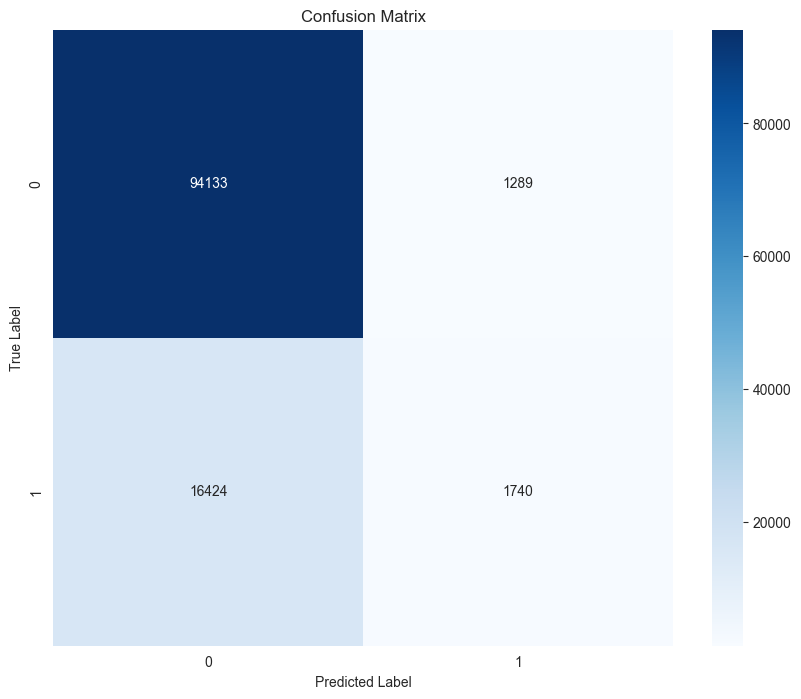

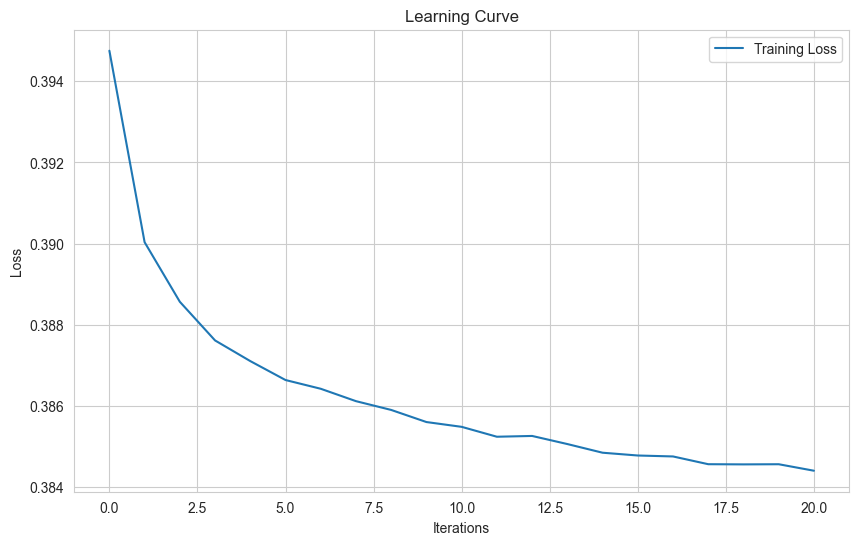

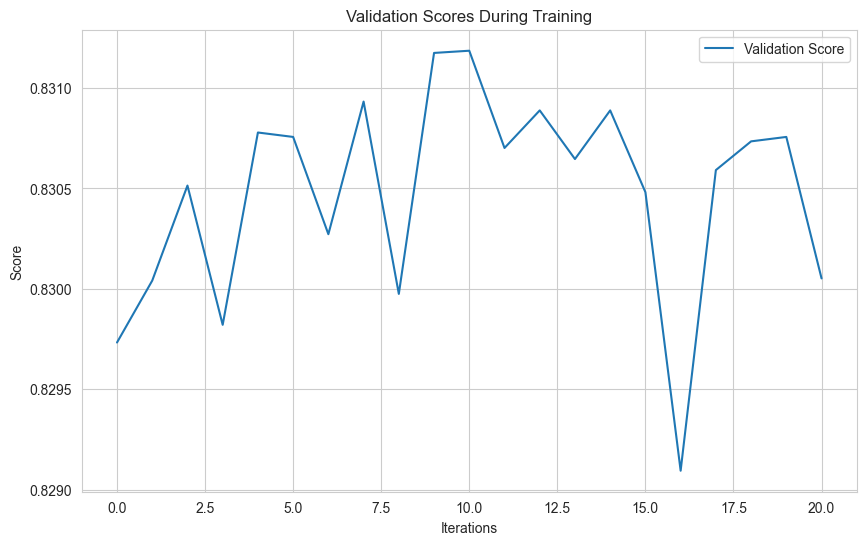

In [20]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot loss curve if available
if hasattr(mlp, 'loss_curve_'):
    plt.figure(figsize=(10, 6))
    plt.plot(mlp.loss_curve_, label='Training Loss')
    plt.title('Learning Curve')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Display validation scores if available
if hasattr(mlp, 'validation_scores_'):
    plt.figure(figsize=(10, 6))
    plt.plot(mlp.validation_scores_, label='Validation Score')
    plt.title('Validation Scores During Training')
    plt.xlabel('Iterations')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

### ***Using the mlp_classifier Module***

To use this notebook as part of the main pipeline, you can import and use `train_and_evaluate()` from `mlp_classifier.py`:

```python
from mlp_classifier import train_and_evaluate

# Get metrics and model
metrics, report, model = train_and_evaluate()
```

This follows our project structure where:
1. Heavy lifting is done in mlp_classifier.py
2. Results are saved to data/mlp_classifier_output/
3. Notebook provides interactive exploration and visualization
4. Main pipeline can easily import and use our module

In [22]:
# Example of using mlp_classifier module
from mlp_classifier import train_and_evaluate

# Run training and evaluation
metrics, report, model = train_and_evaluate()

print("Results from mlp_classifier.py:")
print("-" * 50)
print("\nMetrics:")
for k, v in metrics.items():
    print(f"{k:>10}: {v:.4f}")

print("\nClassification Report:")
print(report)

Loading and preparing data...

Dataset Overview:
--------------------------------------------------
Shape: (567930, 9)
Number of features: 8
Number of samples: 567930
Time period coverage: 1135.0 trading days

Class distribution:
  Big negative moves (<-1.5%): 15.7%
  Small/No moves (-1.5% to 1.5%): 67.1%
  Big positive moves (>1.5%): 17.1%

Training set shape: (454344, 8)
Test set shape: (113586, 8)

Creating and training MLP model...
Iteration 1, loss = 0.39475579
Validation score: 0.829733
Iteration 2, loss = 0.39003459
Validation score: 0.830041
Iteration 3, loss = 0.38856520
Validation score: 0.830514
Iteration 4, loss = 0.38761200
Validation score: 0.829821
Iteration 5, loss = 0.38710277
Validation score: 0.830778
Iteration 6, loss = 0.38663585
Validation score: 0.830756
Iteration 7, loss = 0.38642035
Validation score: 0.830272
Iteration 8, loss = 0.38611495
Validation score: 0.830932
Iteration 9, loss = 0.38589834
Validation score: 0.829975
Iteration 10, loss = 0.38559993
Valida